# **Step 1: Notebook to Create ML Model**
Predict **penguin species** given measurements of the bill, flippers, and body mass, and knowledge about penguin's sex and location

### Installing `scikit-learn`

1. To install `scikit-learn` using `pip`, run the following command: `pip install -U scikit-learn`
2. To install `scikit-learn` using `conda`, run the following command: `conda install -c conda-forge scikit-learn`

In [98]:
# Data handling and manipulation
import pandas as pd                  # Pandas
import numpy as np                   # Numpy

# Visualization
from matplotlib import pyplot as plt # Matplotlib
import seaborn as sns                # Seaborn

# Machine learning algorithms
from sklearn.ensemble import RandomForestRegressor  # Random Forest
from xgboost import XGBRegressor                    # XGBoost Regressor

# Data partitioning
from sklearn.model_selection import train_test_split

# Model evaluation and metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# MAPIE for prediction intervals
from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score

# Tree visualization (optional if needed)
from sklearn import tree

# Package to record time
import time

# Saving/loading Python objects
import pickle 

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Configure inline plots as vector-based (svg)
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']


In [99]:
# Load dataset as dataframe
tv_df = pd.read_csv('Traffic_Volume.csv')
tv_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,10/2/12 9:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,10/2/12 10:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,10/2/12 11:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,10/2/12 12:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,10/2/12 13:00,4918


In [100]:
# Filling null values in holiday section with .fillna
tv_df['holiday'].fillna('None', inplace=True)
tv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   date_time       48204 non-null  object 
 7   traffic_volume  48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [101]:
# Distribution of Species column
tv_df['clouds_all'].value_counts()

clouds_all
90     16442
1      12761
75      5069
40      3993
0       1988
20      1849
64      1558
5       1094
92       776
12       273
8        270
24       186
32       185
88       183
80       181
48       180
68       179
36       169
56       166
76       153
44       147
100       94
99        44
93        34
98        21
87        18
85        17
59        16
96        14
57        13
89        13
91        12
81        11
46         9
97         8
77         7
6          6
63         5
11         5
83         5
16         5
25         4
70         4
58         4
72         3
13         3
3          3
4          3
2          2
50         2
62         2
67         2
42         2
86         2
38         2
60         2
54         2
84         1
17         1
78         1
Name: count, dtype: int64

In [102]:
# Output column for prediction
output = tv_df['traffic_volume']

# Input features
features = tv_df.drop(columns=['traffic_volume'])

# Convert date_time from object to datetime
features['date_time'] = pd.to_datetime(features['date_time'])

# Extract month, weekday, and hour for each entry
### Used ChatGPT to get the full name of the month and weekday
features['month'] = features['date_time'].dt.strftime('%B')
features['weekday'] = features['date_time'].dt.strftime('%A')
features['hour'] = features['date_time'].dt.hour
features.drop(columns=['date_time'], inplace=True)
features['month'] = features['month'].astype('category')
features['weekday'] = features['weekday'].astype('category')

# One-hot encode the categorical variables
cat_var = ['month', 'weekday', 'holiday', 'rain_1h', 'snow_1h', 'weather_main']

features_encoded = pd.get_dummies(features, columns=cat_var)

# Display the first few rows of the encoded features
features_encoded.head()

,temp,clouds_all,hour,month_April,month_August,month_December,month_February,month_January,month_July,month_June,...,weather_main_Clouds,weather_main_Drizzle,weather_main_Fog,weather_main_Haze,weather_main_Mist,weather_main_Rain,weather_main_Smoke,weather_main_Snow,weather_main_Squall,weather_main_Thunderstorm
0,288.28,40,9,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
1,289.36,75,10,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
2,289.58,90,11,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
3,290.13,90,12,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,291.14,75,13,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False


In [103]:
features_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Columns: 429 entries, temp to weather_main_Thunderstorm
dtypes: bool(426), float64(1), int32(1), int64(1)
memory usage: 20.5 MB


In [104]:
# Data partitioning into training and testing
train_X, test_X, train_y, test_y = train_test_split(features_encoded, output, test_size=0.2, random_state=1)

# Define and fit the XGBoost model
xgb_reg = XGBRegressor(objective='reg:squarederror')

xgb_reg.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
# Predict Test Set
y_pred = xgb_reg.predict(test_X)  # Use the trained model instance 'xgb_reg'

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' % r2)

# Calculate RMSE on Test Set (use np.sqrt for RMSE calculation)
RMSE_test = np.sqrt(sklearn.metrics.mean_squared_error(test_y, y_pred))  # Corrected RMSE calculation
print('RMSE on Test Set: %0.2f' % RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 432.38


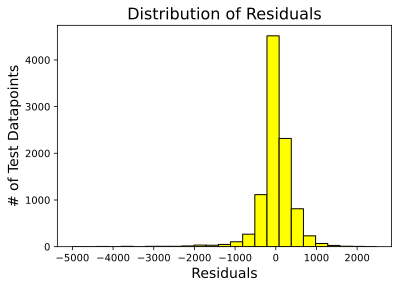

In [124]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = test_y - y_pred

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'yellow', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

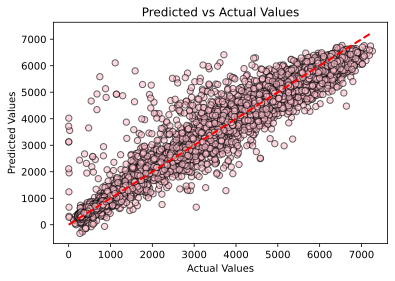

In [125]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(test_y, y_pred, color = 'pink', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

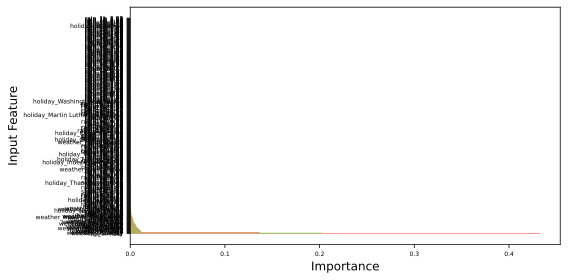

In [123]:
# Storing importance values from the trained model
importance = xgb_reg.feature_importances_

# Storing feature importance as a dataframe
feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
plt.figure(figsize=(8, 4))
plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['red', 'lime'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.yticks(fontsize = 6)
plt.xticks(fontsize = 6)

plt.tight_layout();

In [109]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = xgb_reg, # Prediction model to use
                       n_jobs = -1,
                       random_state = 1)

# Fit mapie regressor on training data
start = time.time()  
mapie.fit(train_X, train_y)
stop = time.time()             
print(f"Training time: {stop - start}s")

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)

Training time: 6.967327117919922s


In [110]:
# Predicted values
y_test_pred

array([ 887.2253, 1302.6144, 2014.6495, ..., 1672.1184, 4606.932 ,
       4692.9614], dtype=float32)

In [111]:
# Prediction Intervals
y_test_pis

array([[[ 280.53741455],
        [1446.67712402]],

       [[ 626.02526855],
        [1791.08813477]],

       [[1422.54553223],
        [2615.30480957]],

       ...,

       [[1090.96582031],
        [2259.60498047]],

       [[4070.0769043 ],
        [5256.58496094]],

       [[4086.86865234],
        [5257.74365234]]])

In [112]:
# Storing results in a dataframe
predictions = test_y.to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
36845,4720,4363.020020,3841.50,5006.89
9943,3185,2139.060059,1595.20,2761.97
19981,1741,1672.119995,1090.97,2259.60
19918,4611,4606.930176,4070.08,5256.58
28318,4556,4692.959961,4086.87,5257.74


In [117]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.15%


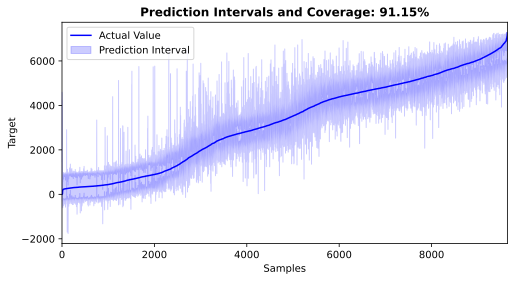

In [131]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'blue', markersize=8, label="Actual Value", linewidth=3)

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="blue", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

### Save your prediction model and load it later to make predictions

**Using Pickle**

 <img src="https://d33wubrfki0l68.cloudfront.net/0f66116c250285870171e38f309161bafc25f06b/dbd4c/assets/images/posts/pickled-cabbage.jpg" width="350" style="float: center"/>

**Pickle** is a useful Python tool that allows you to save your ML models, to minimise lengthy re-training and allow you to share, commit, and re-load pre-trained machine learning models.

In [113]:
# Pickle file: saving the trained DT model
# Creating the file where we want to write the model
xgb_pickle = open('xgb_tvp.pickle', 'wb') 

# Write DT model to the file
pickle.dump(xgb_reg, xgb_pickle) 

# Close the file
xgb_pickle.close() 